## Business Problem:

***One of the global banks would like to understand what factors driving credit card spend are. The bank wants to use these insights to calculate credit limit. In order to solve the problem, the bank conducted survey of 5000 customers and collected data.
The objective of this case study is to understand what's driving the total spend (Primary Card + Secondary card). Given the factors, predict credit limit for the new applicants***


## Data Availability:

- Data for the case are available in xlsx format(Data Set.xlxs).
- The data have been provided for 5000 customers.
- Detailed data dictionary has been provided for understanding the data in the data.
- Data is encoded in the numerical format to reduce the size of the data however some of the variables are categorical. You can  find the details in the data dictionary


In [839]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn
import scipy.stats as stats

In [840]:
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold = -1)
np.set_printoptions(precision = 3)

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [841]:
import pandas_profiling

In [842]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [843]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

### Import Data

In [844]:
card = pd.read_excel('C:/Users/Mr.X/Documents/Python Classes/MachineLearning/DataSet.xlsx')
card.shape

(5000, 130)

In [845]:
card.columns

Index(['custid', 'region', 'townsize', 'gender', 'age', 'agecat', 'birthmonth',
       'ed', 'edcat', 'jobcat',
       ...
       'owncd', 'ownpda', 'ownpc', 'ownipod', 'owngame', 'ownfax', 'news',
       'response_01', 'response_02', 'response_03'],
      dtype='object', length=130)

In [846]:
# profiling using pandas profiling
# report = pandas_profiling.ProfileReport(card)

In [847]:
# export the file as html
# screen the variables to get rid of unuseful variable sin the begining or
# make a note of potential variables for model refinement
# report.to_file(output_file = 'CradSpend.html')

### Creating the dependent variable

In [848]:
#To create Y we need to sumup cardspent(first card spent amount) and card2spent(Second card spent amount)
card['totalspend'] = card['cardspent'] + card['card2spent']

In [849]:
card.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,union,employ,empcat,retire,income,lninc,inccat,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,default,jobsat,marital,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,homeown,hometype,address,addresscat,cars,carown,cartype,carvalue,carcatvalue,carbought,carbuy,commute,commutecat,commutetime,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenure,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenure,card2tenurecat,cardspent,card2spent,active,bfast,tenure,churn,longmon,lnlongmon,longten,lnlongten,tollfree,tollmon,lntollmon,tollten,lntollten,equip,equipmon,lnequipmon,equipten,lnequipten,callcard,cardmon,lncardmon,cardten,lncardten,wireless,wiremon,lnwiremon,wireten,lnwireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,totalspend
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,1,0,1,0,31,3.433987,2,11.1,1.200909,0.183079,2.240091,0.806516,1,1,0,-1,-1,3,0,0,0,0,0,0,0,0,0,2,0,1,2,1,0,14.3,1,0,0,8,4,22.0,0,1,1,0,0,0,0,1,0,0,9,6,1,0,1,3,1,1,0,2,2,5,3,1,0,3,2,81.66,67.80,0,3,5,1,6.50,1.871802,34.40,3.538057,1,29.0,3.367296,161.05,5.081715,1,29.50,3.384390,126.1,4.837075,1,14.25,2.656757,60.0,4.094345,0,0.00,NaN,0.00,NaN,1,1,1,0,0,1,1,1,0,1,13,1,1,0,0,0,1,1,0,0,0,1,0,149.46
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,0,0,1,0,15,2.708050,1,18.6,1.222020,0.200505,1.567980,0.449788,1,1,0,-1,-1,2,6,0,0,0,0,0,0,6,1,3,2,1,2,1,1,6.8,1,0,0,1,1,29.0,1,0,0,1,0,0,1,0,1,1,9,4,1,0,0,2,4,1,0,4,2,4,1,3,0,4,2,42.60,34.94,1,1,39,0,8.90,2.186051,330.60,5.800909,0,0.0,NaN,0.00,NaN,1,54.85,4.004602,1975.0,7.588324,1,16.00,2.772589,610.0,6.413459,1,45.65,3.821004,1683.55,7.428660,1,1,1,4,1,0,1,0,1,1,18,1,1,1,1,1,1,1,1,1,0,0,0,77.54
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,0,16,5,0,35,3.555348,2,9.9,0.928620,-0.074056,2.536380,0.930738,0,4,1,13,2,3,3,2,1,0,0,0,0,0,1,1,30,5,3,1,1,18.8,1,0,1,4,3,24.0,1,0,1,1,1,0,0,0,0,0,2,5,1,0,0,2,1,4,0,35,5,4,1,3,0,25,5,184.22,175.75,0,3,65,0,28.40,3.346389,1858.35,7.527444,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.0,NaN,1,23.00,3.135494,1410.0,7.251345,0,0.00,NaN,0.00,NaN,1,0,0,0,0,0,0,0,0,1,21,1,1,1,0,0,0,0,0,1,0,0,0,359.97
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,0,0,1,0,20,2.995732,1,5.7,0.022800,-3.780995,1.117200,0.110826,1,2,1,18,4,5,0,0,0,0,0,0,0,0,1,3,3,2,3,1,1,8.7,1,0,1,1,1,38.0,1,0,0,0,0,0,0,0,0,0,9,3,0,0,0,2,1,4,0,5,2,3,2,4,0,5,2,340.99,18.42,1,1,36,0,6.00,1.791759,199.45,5.295564,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.0,NaN,1,21.00,3.044522,685.0,6.529419,0,0.00,NaN,0.00,NaN,1,0,0,2,0,0,0,0,1,1,26,1,1,1,0,1,1,1,0,1,1,0,0,359.41
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,0,1,1,0,23,3.135494,1,1.7,0.214659,-1.538705,0.176341,-1.735336,0,1,1,13,2,4,0,0,0,0,0,0,0,0,0,2,3,2,1,0,1,10.6,1,0,1,6,3,32.0,0,0,0,0,0,1,0,1,0,0,9,4,0,0,0,4,2,1,0,8,3,1,3,2,0,9,3,255.10,252.73,1,3,21,0,3.05,1.115142,74.10,4.305416,1,16.5,2.803360,387.70,5.960232,0,0.00,NaN,0.0,NaN,1,17.25,2.847812,360.0,5.886104,1,19.05,2.947067,410.80,6.018106,0,1,0,3,1,1,1,1,0,1,27,1,1,1,0,1,0,1,0,0,0,1,0,507.83


### Drop The Unnecessary variable

In [850]:
#Drop cardspent(first card spent amount) and card2spent(Second card spent amount) because its not adding any value
#Also  we are droping "custid","birthmonth" bacuse cust id is unique and birth month is not adding any value

card.drop(['cardspent', 'card2spent', 'custid', 'birthmonth'], axis=1, inplace=True)

In [851]:
card.head()

,region,townsize,gender,age,agecat,ed,edcat,jobcat,union,employ,empcat,retire,income,lninc,inccat,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,default,jobsat,marital,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,homeown,hometype,address,addresscat,cars,carown,cartype,carvalue,carcatvalue,carbought,carbuy,commute,commutecat,commutetime,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenure,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenure,card2tenurecat,active,bfast,tenure,churn,longmon,lnlongmon,longten,lnlongten,tollfree,tollmon,lntollmon,tollten,lntollten,equip,equipmon,lnequipmon,equipten,lnequipten,callcard,cardmon,lncardmon,cardten,lncardten,wireless,wiremon,lnwiremon,wireten,lnwireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,totalspend
0,1,2.0,1,20,2,15,3,1,1,0,1,0,31,3.433987,2,11.1,1.200909,0.183079,2.240091,0.806516,1,1,0,-1,-1,3,0,0,0,0,0,0,0,0,0,2,0,1,2,1,0,14.3,1,0,0,8,4,22.0,0,1,1,0,0,0,0,1,0,0,9,6,1,0,1,3,1,1,0,2,2,5,3,1,0,3,2,0,3,5,1,6.50,1.871802,34.40,3.538057,1,29.0,3.367296,161.05,5.081715,1,29.50,3.384390,126.1,4.837075,1,14.25,2.656757,60.0,4.094345,0,0.00,NaN,0.00,NaN,1,1,1,0,0,1,1,1,0,1,13,1,1,0,0,0,1,1,0,0,0,1,0,149.46
1,5,5.0,0,22,2,17,4,2,0,0,1,0,15,2.708050,1,18.6,1.222020,0.200505,1.567980,0.449788,1,1,0,-1,-1,2,6,0,0,0,0,0,0,6,1,3,2,1,2,1,1,6.8,1,0,0,1,1,29.0,1,0,0,1,0,0,1,0,1,1,9,4,1,0,0,2,4,1,0,4,2,4,1,3,0,4,2,1,1,39,0,8.90,2.186051,330.60,5.800909,0,0.0,NaN,0.00,NaN,1,54.85,4.004602,1975.0,7.588324,1,16.00,2.772589,610.0,6.413459,1,45.65,3.821004,1683.55,7.428660,1,1,1,4,1,0,1,0,1,1,18,1,1,1,1,1,1,1,1,1,0,0,0,77.54
2,3,4.0,1,67,6,14,2,2,0,16,5,0,35,3.555348,2,9.9,0.928620,-0.074056,2.536380,0.930738,0,4,1,13,2,3,3,2,1,0,0,0,0,0,1,1,30,5,3,1,1,18.8,1,0,1,4,3,24.0,1,0,1,1,1,0,0,0,0,0,2,5,1,0,0,2,1,4,0,35,5,4,1,3,0,25,5,0,3,65,0,28.40,3.346389,1858.35,7.527444,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.0,NaN,1,23.00,3.135494,1410.0,7.251345,0,0.00,NaN,0.00,NaN,1,0,0,0,0,0,0,0,0,1,21,1,1,1,0,0,0,0,0,1,0,0,0,359.97
3,4,3.0,0,23,2,16,3,2,0,0,1,0,20,2.995732,1,5.7,0.022800,-3.780995,1.117200,0.110826,1,2,1,18,4,5,0,0,0,0,0,0,0,0,1,3,3,2,3,1,1,8.7,1,0,1,1,1,38.0,1,0,0,0,0,0,0,0,0,0,9,3,0,0,0,2,1,4,0,5,2,3,2,4,0,5,2,1,1,36,0,6.00,1.791759,199.45,5.295564,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.0,NaN,1,21.00,3.044522,685.0,6.529419,0,0.00,NaN,0.00,NaN,1,0,0,2,0,0,0,0,1,1,26,1,1,1,0,1,1,1,0,1,1,0,0,359.41
4,2,2.0,0,26,3,16,3,2,0,1,1,0,23,3.135494,1,1.7,0.214659,-1.538705,0.176341,-1.735336,0,1,1,13,2,4,0,0,0,0,0,0,0,0,0,2,3,2,1,0,1,10.6,1,0,1,6,3,32.0,0,0,0,0,0,1,0,1,0,0,9,4,0,0,0,4,2,1,0,8,3,1,3,2,0,9,3,1,3,21,0,3.05,1.115142,74.10,4.305416,1,16.5,2.803360,387.70,5.960232,0,0.00,NaN,0.0,NaN,1,17.25,2.847812,360.0,5.886104,1,19.05,2.947067,410.80,6.018106,0,1,0,3,1,1,1,1,0,1,27,1,1,1,0,1,0,1,0,0,0,1,0,507.83


### Check linearlity of data:

1. Use scatter plot by using 'df.plot' or if you want a linear line you can use 'sns.lmplot' through seaborn.

In [852]:
import seaborn as sns

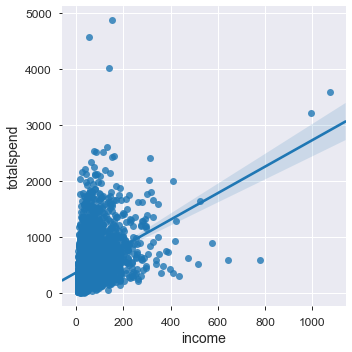

In [853]:
# Seaborn scatter plot with regression line
# aspect=1.5, scatter_kws={'alpha':0.2}) - You can choose this option too.
sns.lmplot(x ='income', y ='totalspend', data = card)

So we can see above most data points are near to line which means our data is normal and we can go ahed for further process.

In [854]:
# Creating Categorical List = Contains categorical variables...

for x in ['region','townsize','gender','agecat','edcat','jobcat','union','employ','empcat','retire','inccat',
          'default','jobsat','marital','spousedcat','homeown','hometype','address','addresscat','cars','carown',
          'cartype','carcatvalue','carbought','carbuy','commute','commutecat','commutecar','commutemotorcycle',
          'commutecarpool','commutebus','commuterail','commutepublic','commutebike','commutewalk','commutenonmotor',
          'telecommute','reason','polview','polparty','polcontrib','vote','card','cardtype','cardbenefit',
         'cardfee','cardtenure','cardtenurecat','card2','card2type','card2benefit','card2fee','card2tenure',
          'card2tenurecat','active','bfast','churn','tollfree','equip','callcard','wireless','multline','voice',
          'pager','internet','callid','callwait','forward','confer','ebill','owntv','ownvcr','owndvd','owncd',
          'ownpda','ownpc','ownipod','owngame','ownfax','news','response_01','response_02','response_03']:
    card[x] = card[x].astype('object')

In [855]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 127 entries, region to totalspend
dtypes: float64(29), int64(15), object(83)
memory usage: 4.8+ MB


In [856]:
card.shape

(5000, 127)

### Separate numerical and categorical variable

To do that you need to apply for loop along with if condition.

In [857]:
print(dir(dict))

['__class__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'pop', 'popitem', 'setdefault', 'update', 'values']


In [858]:
d = dict(card.dtypes)
d.keys()

dict_keys(['region', 'townsize', 'gender', 'age', 'agecat', 'ed', 'edcat', 'jobcat', 'union', 'employ', 'empcat', 'retire', 'income', 'lninc', 'inccat', 'debtinc', 'creddebt', 'lncreddebt', 'othdebt', 'lnothdebt', 'default', 'jobsat', 'marital', 'spoused', 'spousedcat', 'reside', 'pets', 'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish', 'homeown', 'hometype', 'address', 'addresscat', 'cars', 'carown', 'cartype', 'carvalue', 'carcatvalue', 'carbought', 'carbuy', 'commute', 'commutecat', 'commutetime', 'commutecar', 'commutemotorcycle', 'commutecarpool', 'commutebus', 'commuterail', 'commutepublic', 'commutebike', 'commutewalk', 'commutenonmotor', 'telecommute', 'reason', 'polview', 'polparty', 'polcontrib', 'vote', 'card', 'cardtype', 'cardbenefit', 'cardfee', 'cardtenure', 'cardtenurecat', 'card2', 'card2type', 'card2benefit', 'card2fee', 'card2tenure', 'card2tenurecat', 'active', 'bfast', 'tenure', 'churn', 'longmon', 'lnlongmon'

In [859]:
# Find numerical variable in Data frame.
# This will return a list
numeric_var_names = [key for key in dict(card.dtypes) if dict(card.dtypes)[key] in ['float64','int64','float32','int32']]
# Find Categorical variable in Data frame
cat_var_names = [key for key in dict(card.dtypes) if dict(card.dtypes)[key] in ['object']]


#Print the data frame
print("************ Continous Variable ************")
print( numeric_var_names)
print("************ Categorical Variable ************")
print(cat_var_names)

************ Continous Variable ************
['age', 'ed', 'income', 'lninc', 'debtinc', 'creddebt', 'lncreddebt', 'othdebt', 'lnothdebt', 'spoused', 'reside', 'pets', 'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish', 'carvalue', 'commutetime', 'tenure', 'longmon', 'lnlongmon', 'longten', 'lnlongten', 'tollmon', 'lntollmon', 'tollten', 'lntollten', 'equipmon', 'lnequipmon', 'equipten', 'lnequipten', 'cardmon', 'lncardmon', 'cardten', 'lncardten', 'wiremon', 'lnwiremon', 'wireten', 'lnwireten', 'hourstv', 'totalspend']
************ Categorical Variable ************
['region', 'townsize', 'gender', 'agecat', 'edcat', 'jobcat', 'union', 'employ', 'empcat', 'retire', 'inccat', 'default', 'jobsat', 'marital', 'spousedcat', 'homeown', 'hometype', 'address', 'addresscat', 'cars', 'carown', 'cartype', 'carcatvalue', 'carbought', 'carbuy', 'commute', 'commutecat', 'commutecar', 'commutemotorcycle', 'commutecarpool', 'commutebus', 'commuter

In [860]:
# Converting a list into dataframe
card_num = card[numeric_var_names]

In [861]:
# Converting a cat list into dataframe
card_cat = card[cat_var_names]

### Creating a Summary statistics 

In [862]:
# Appling numeric stats
num_summary = card_num.apply(continuous_var_summary).T
num_summary.head()

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,5000.0,0.0,235128.000000,47.025600,47.000000,17.770338,315.784902,18.000000,18.000000,20.000000,23.000000,31.000000,47.000000,62.000000,72.000000,76.000000,79.000000,79.000000
ed,5000.0,0.0,72715.000000,14.543000,14.000000,3.281083,10.765504,6.000000,8.000000,9.000000,10.000000,12.000000,14.000000,17.000000,19.000000,20.000000,21.000000,23.000000
income,5000.0,0.0,273798.000000,54.759600,38.000000,55.377511,3066.668742,9.000000,9.000000,13.000000,16.000000,24.000000,38.000000,67.000000,109.100000,147.000000,272.010000,1073.000000
lninc,5000.0,0.0,18499.546992,3.699909,3.637586,0.747072,0.558116,2.197225,2.197225,2.564949,2.772589,3.178054,3.637586,4.204693,4.692261,4.990433,5.605839,6.978214
debtinc,5000.0,0.0,49770.800000,9.954160,8.800000,6.399783,40.957226,0.000000,0.700000,1.900000,2.800000,5.100000,8.800000,13.600000,18.600000,22.200000,29.200000,43.100000


In [863]:
# Applting categorical variable stats.
cat_summary = card_cat.apply(categorical_var_summary).T
cat_summary.head()

,N,NMISS,MODE,FREQ,PERCENT
region,5000.0,0.0,5.0,1027.0,20.54
townsize,4998.0,2.0,1.0,1436.0,28.73
gender,5000.0,0.0,1.0,2518.0,50.36
agecat,5000.0,0.0,4.0,1222.0,24.44
edcat,5000.0,0.0,2.0,1567.0,31.34


### Handling Outliers
#### There are some extreame high or extream low value which need to rectify so that it will not have impact on our model

In [864]:
#Handling Outliers for numerical data - Through function

def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

card_num = card_num.apply(lambda x: outlier_capping(x))

In [865]:
card_num.apply(continuous_var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,5000.0,0.0,2.351280e+05,47.025600,47.000000,17.770338,315.784902,18.000000,18.000000,20.000000,23.000000,31.000000,47.000000,62.000000,72.000000,76.000000,79.000000,79.000000
ed,5000.0,0.0,7.272100e+04,14.544200,14.000000,3.242553,10.514149,8.000000,8.000000,9.000000,10.000000,12.000000,14.000000,17.000000,19.000000,20.000000,21.000000,21.000000
income,5000.0,0.0,2.681495e+05,53.629900,38.000000,46.567698,2168.550537,9.000000,9.000000,13.000000,16.000000,24.000000,38.000000,67.000000,109.100000,147.000000,272.000100,272.010000
lninc,5000.0,0.0,1.848525e+04,3.697049,3.637586,0.738495,0.545375,2.197225,2.197225,2.564949,2.772589,3.178054,3.637586,4.204693,4.692261,4.990433,5.605802,5.605839
debtinc,5000.0,0.0,4.957060e+04,9.914120,8.800000,6.241691,38.958700,0.700000,0.700000,1.900000,2.800000,5.100000,8.800000,13.600000,18.600000,22.200000,29.200000,29.200000
creddebt,5000.0,0.0,8.791845e+03,1.758369,0.926437,2.380681,5.667644,0.033160,0.033166,0.101088,0.175682,0.385520,0.926437,2.063820,4.299470,6.373010,14.280004,14.280358
lncreddebt,4999.0,1.0,-6.387705e+02,-0.127780,-0.076106,1.241398,1.541068,-3.401690,-3.401599,-2.291604,-1.737842,-0.952685,-0.076106,0.724665,1.458625,1.852297,2.658861,2.658910
othdebt,5000.0,0.0,1.761253e+04,3.522506,2.098540,4.221760,17.823256,0.114299,0.114312,0.287692,0.457997,0.980301,2.098540,4.314780,8.062046,11.815981,24.062466,24.064260
lnothdebt,4999.0,1.0,3.491233e+03,0.698386,0.741537,1.104530,1.219987,-2.168241,-2.168229,-1.243483,-0.780312,-0.018987,0.741537,1.462053,2.087178,2.469586,3.180655,3.180802
spoused,5000.0,0.0,3.047700e+04,6.095400,-1.000000,7.709565,59.437386,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,14.000000,16.000000,18.000000,20.000000,20.000000


### Handling  Missing Values

#### As we can see in the above audit report some data is missing in nmerical data set and some are missing in categorical.
#### We will treat numerical missing data with mean() and categorical data with mode()

In [866]:
#Handling missings - by Function (Make the function to treat all data in one shot)

def Missing_imputation(x):
    x = x.fillna(x.mean())
    return x

card_num = card_num.apply(lambda x: Missing_imputation(x))

In [867]:
card_num.apply(continuous_var_summary).T.head(10)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,5000.0,0.0,235128.000000,47.025600,47.000000,17.770338,315.784902,18.000000,18.000000,20.000000,23.000000,31.000000,47.000000,62.000000,72.000000,76.000000,79.000000,79.000000
ed,5000.0,0.0,72721.000000,14.544200,14.000000,3.242553,10.514149,8.000000,8.000000,9.000000,10.000000,12.000000,14.000000,17.000000,19.000000,20.000000,21.000000,21.000000
income,5000.0,0.0,268149.500000,53.629900,38.000000,46.567698,2168.550537,9.000000,9.000000,13.000000,16.000000,24.000000,38.000000,67.000000,109.100000,147.000000,272.000100,272.010000
lninc,5000.0,0.0,18485.246078,3.697049,3.637586,0.738495,0.545375,2.197225,2.197225,2.564949,2.772589,3.178054,3.637586,4.204693,4.692261,4.990433,5.605802,5.605839
debtinc,5000.0,0.0,49570.600000,9.914120,8.800000,6.241691,38.958700,0.700000,0.700000,1.900000,2.800000,5.100000,8.800000,13.600000,18.600000,22.200000,29.200000,29.200000
creddebt,5000.0,0.0,8791.844708,1.758369,0.926437,2.380681,5.667644,0.033160,0.033166,0.101088,0.175682,0.385520,0.926437,2.063820,4.299470,6.373010,14.280004,14.280358
lncreddebt,5000.0,0.0,-638.898266,-0.127780,-0.076409,1.241273,1.540760,-3.401690,-3.401598,-2.291595,-1.737699,-0.952498,-0.076409,0.724559,1.458492,1.852071,2.658860,2.658910
othdebt,5000.0,0.0,17612.530669,3.522506,2.098540,4.221760,17.823256,0.114299,0.114312,0.287692,0.457997,0.980301,2.098540,4.314780,8.062046,11.815981,24.062466,24.064260
lnothdebt,5000.0,0.0,3491.931089,0.698386,0.741242,1.104420,1.219743,-2.168241,-2.168229,-1.243358,-0.780244,-0.018535,0.741242,1.462046,2.087167,2.469453,3.180654,3.180802
spoused,5000.0,0.0,30477.000000,6.095400,-1.000000,7.709565,59.437386,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,14.000000,16.000000,18.000000,20.000000,20.000000


In [868]:
#Handling missings - by Function (Makethe function to treat all data in one shot)

def Missing_imputation(x):
    x = x.fillna(x.mode())
    return x

card_cat = card_cat.apply(lambda x: Missing_imputation(x))

In [869]:
card_cat.apply(categorical_var_summary).T.head(10)

,N,NMISS,MODE,FREQ,PERCENT
region,5000.0,0.0,5.0,1027.0,20.54
townsize,4998.0,2.0,1.0,1436.0,28.73
gender,5000.0,0.0,1.0,2518.0,50.36
agecat,5000.0,0.0,4.0,1222.0,24.44
edcat,5000.0,0.0,2.0,1567.0,31.34
jobcat,5000.0,0.0,2.0,1640.0,32.80
union,5000.0,0.0,0.0,4244.0,84.88
employ,5000.0,0.0,0.0,659.0,13.18
empcat,5000.0,0.0,2.0,1180.0,23.60
retire,5000.0,0.0,0.0,4262.0,85.24


#### Again check the missing values has been treated or not

In [870]:
print('Missing values in numerical data : ', card_cat.isnull().sum().values.sum())
print('Missing values in categorical data : ', card_num.isnull().sum().values.sum())

Missing values in numerical data :  2
Missing values in categorical data :  0


### Dummy creation for categorical data

In [871]:
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname)
    col_dummies.drop(col_dummies.columns[0], axis = 1, inplace = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True)
    return df

In [872]:
# card.loc[:, card.dtypes == 'object'].shape
cat_varlist = list(card_cat.columns)

In [873]:
for x in cat_varlist:
    card_cat[x] = card[x].astype('category')
    card_cat = create_dummies(card_cat, x)
    

In [874]:
card_cat.sample(5)

,region_2,region_3,region_4,region_5,townsize_2.0,townsize_3.0,townsize_4.0,townsize_5.0,gender_1,agecat_3,agecat_4,agecat_5,agecat_6,edcat_2,edcat_3,edcat_4,edcat_5,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,employ_1,employ_2,employ_3,employ_4,employ_5,employ_6,employ_7,employ_8,employ_9,employ_10,employ_11,employ_12,employ_13,employ_14,employ_15,employ_16,employ_17,employ_18,employ_19,employ_20,employ_21,employ_22,employ_23,employ_24,employ_25,employ_26,employ_27,employ_28,employ_29,employ_30,employ_31,employ_32,employ_33,employ_34,employ_35,employ_36,employ_37,employ_38,employ_39,employ_40,employ_41,employ_42,employ_43,employ_44,employ_45,employ_46,employ_47,employ_48,employ_49,employ_51,employ_52,empcat_2,empcat_3,empcat_4,empcat_5,retire_1,inccat_2,inccat_3,inccat_4,inccat_5,default_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,marital_1,spousedcat_1,spousedcat_2,spousedcat_3,spousedcat_4,spousedcat_5,homeown_1,hometype_2,hometype_3,hometype_4,address_1,address_2,address_3,address_4,address_5,address_6,address_7,address_8,address_9,address_10,address_11,address_12,address_13,address_14,address_15,address_16,address_17,address_18,address_19,address_20,address_21,address_22,address_23,address_24,address_25,address_26,address_27,address_28,address_29,address_30,address_31,address_32,address_33,address_34,address_35,address_36,address_37,address_38,address_39,address_40,address_41,address_42,address_43,address_44,address_45,address_46,address_47,address_48,address_49,address_50,address_51,address_52,address_53,address_54,address_55,address_57,addresscat_2,addresscat_3,addresscat_4,addresscat_5,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,carown_0,carown_1,cartype_0,cartype_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_0,carbought_1,carbuy_1,commute_2,commute_3,commute_4,commute_5,commute_6,commute_7,commute_8,commute_9,commute_10,commutecat_2,commutecat_3,commutecat_4,commutecat_5,commutecar_1,commutemotorcycle_1,commutecarpool_1,commutebus_1,commuterail_1,commutepublic_1,commutebike_1,commutewalk_1,commutenonmotor_1,telecommute_1,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,polparty_1,polcontrib_1,vote_1,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,cardtenure_1,cardtenure_2,cardtenure_3,cardtenure_4,cardtenure_5,cardtenure_6,cardtenure_7,cardtenure_8,cardtenure_9,cardtenure_10,cardtenure_11,cardtenure_12,cardtenure_13,cardtenure_14,cardtenure_15,cardtenure_16,cardtenure_17,cardtenure_18,cardtenure_19,cardtenure_20,cardtenure_21,cardtenure_22,cardtenure_23,cardtenure_24,cardtenure_25,cardtenure_26,cardtenure_27,cardtenure_28,cardtenure_29,cardtenure_30,cardtenure_31,cardtenure_32,cardtenure_33,cardtenure_34,cardtenure_35,cardtenure_36,cardtenure_37,cardtenure_38,cardtenure_39,cardtenure_40,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenure_1,card2tenure_2,card2tenure_3,card2tenure_4,card2tenure_5,card2tenure_6,card2tenure_7,card2tenure_8,card2tenure_9,card2tenure_10,card2tenure_11,card2tenure_12,card2tenure_13,card2tenure_14,card2tenure_15,card2tenure_16,card2tenure_17,card2tenure_18,card2tenure_19,card2tenure_20,card2tenure_21,card2tenure_22,card2tenure_23,card2tenure_24,card2tenure_25,card2tenure_26,card2tenure_27,card2tenure_28,card2tenure_29,card2tenure_30,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,active_1,bfast_2,bfast_3,churn_1,tollfree_1,equip_1,callcard_1,wireless_1,multline_1,voice_1,pager_1,internet_1,internet_2,internet_3,internet_4,callid_1,callwait_1,forward_1,confer_1,ebill_1,owntv_1,ownvcr_1,owndvd_1,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
2722,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0

### Merge both numeric and categorical variale

In [875]:
df = pd.concat([card_num, card_cat], axis = 1)

In [876]:
df.head()

,age,ed,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,tenure,longmon,lnlongmon,longten,lnlongten,tollmon,lntollmon,tollten,lntollten,equipmon,lnequipmon,equipten,lnequipten,cardmon,lncardmon,cardten,lncardten,wiremon,lnwiremon,wireten,lnwireten,hourstv,totalspend,region_2,region_3,region_4,region_5,townsize_2.0,townsize_3.0,townsize_4.0,townsize_5.0,gender_1,agecat_3,agecat_4,agecat_5,agecat_6,edcat_2,edcat_3,edcat_4,edcat_5,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,employ_1,employ_2,employ_3,employ_4,employ_5,employ_6,employ_7,employ_8,employ_9,employ_10,employ_11,employ_12,employ_13,employ_14,employ_15,employ_16,employ_17,employ_18,employ_19,employ_20,employ_21,employ_22,employ_23,employ_24,employ_25,employ_26,employ_27,employ_28,employ_29,employ_30,employ_31,employ_32,employ_33,employ_34,employ_35,employ_36,employ_37,employ_38,employ_39,employ_40,employ_41,employ_42,employ_43,employ_44,employ_45,employ_46,employ_47,employ_48,employ_49,employ_51,employ_52,empcat_2,empcat_3,empcat_4,empcat_5,retire_1,inccat_2,inccat_3,inccat_4,inccat_5,default_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,marital_1,spousedcat_1,spousedcat_2,spousedcat_3,spousedcat_4,spousedcat_5,homeown_1,hometype_2,hometype_3,hometype_4,address_1,address_2,address_3,address_4,address_5,address_6,address_7,address_8,address_9,address_10,address_11,address_12,address_13,address_14,address_15,address_16,address_17,address_18,address_19,address_20,address_21,address_22,address_23,address_24,address_25,address_26,address_27,address_28,address_29,address_30,address_31,address_32,address_33,address_34,address_35,address_36,address_37,address_38,address_39,address_40,address_41,address_42,address_43,address_44,address_45,address_46,address_47,address_48,address_49,address_50,address_51,address_52,address_53,address_54,address_55,address_57,addresscat_2,addresscat_3,addresscat_4,addresscat_5,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,carown_0,carown_1,cartype_0,cartype_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_0,carbought_1,carbuy_1,commute_2,commute_3,commute_4,commute_5,commute_6,commute_7,commute_8,commute_9,commute_10,commutecat_2,commutecat_3,commutecat_4,commutecat_5,commutecar_1,commutemotorcycle_1,commutecarpool_1,commutebus_1,commuterail_1,commutepublic_1,commutebike_1,commutewalk_1,commutenonmotor_1,telecommute_1,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,polparty_1,polcontrib_1,vote_1,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,cardtenure_1,cardtenure_2,cardtenure_3,cardtenure_4,cardtenure_5,cardtenure_6,cardtenure_7,cardtenure_8,cardtenure_9,cardtenure_10,cardtenure_11,cardtenure_12,cardtenure_13,cardtenure_14,cardtenure_15,cardtenure_16,cardtenure_17,cardtenure_18,cardtenure_19,cardtenure_20,cardtenure_21,cardtenure_22,cardtenure_23,cardtenure_24,cardtenure_25,cardtenure_26,cardtenure_27,cardtenure_28,cardtenure_29,cardtenure_30,cardtenure_31,cardtenure_32,cardtenure_33,cardtenure_34,cardtenure_35,cardtenure_36,cardtenure_37,cardtenure_38,cardtenure_39,cardtenure_40,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenure_1,card2tenure_2,card2tenure_3,card2tenure_4,card2tenure_5,card2tenure_6,card2tenure_7,card2tenure_8,card2tenure_9,card2tenure_10,card2tenure_11,card2tenure_12,card2tenure_13,card2tenure_14,card2tenure_15,card2tenure_16,card2tenure_17,card2tenure_18,card2tenure_19,card2tenure_20,card2tenure_21,card2tenure_22,card2tenure_23,card2tenure_24,card2tenure_25,card2tenure_26,card2tenure_27,card2tenure_28,card2tenure_29,card2tenure_30,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,active_1,bfast_2,bfas

In [877]:
df.shape

(5000, 389)

### Explore data and check the variable distribution

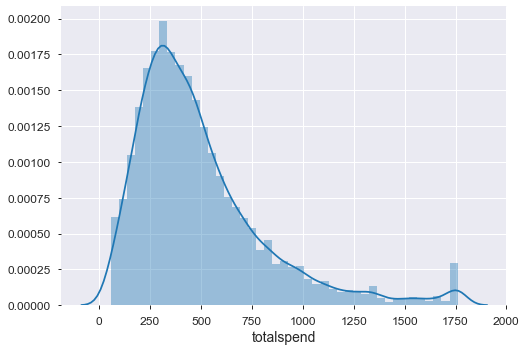

In [878]:
sns.distplot(df.totalspend)

**Now as you can see distribution is right skewed so we need to take log and then plot the graph.**

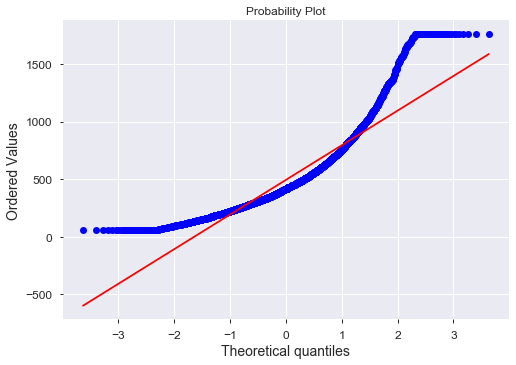

In [879]:
from scipy import stats
import pylab

stats.probplot(df.totalspend, dist="norm", plot=pylab )
pylab.show()

***As we can see above graph our data is not distributed normally perfectly, so we will use boxcox techniue to make it perfect normal***

In [880]:
# check the skewness of the data
df.totalspend.skew()

1.615173337243418

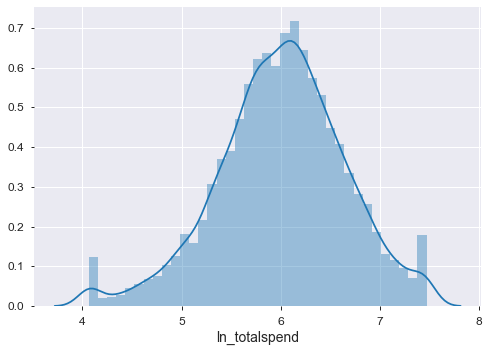

In [881]:
df['ln_totalspend'] = np.log(df['totalspend'])

sns.distplot(df['ln_totalspend'])
plt.show()

In [882]:
# check the skewness of the data
df.ln_totalspend.skew()

-0.30005358806310334

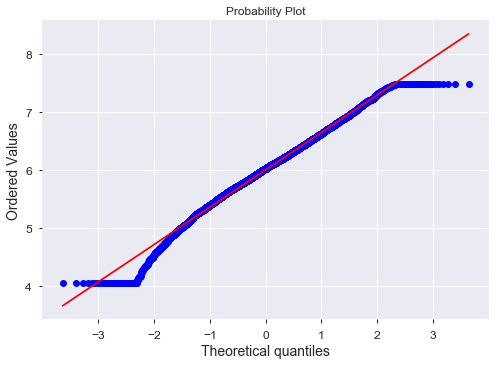

In [883]:
stats.probplot(df.ln_totalspend, dist="norm", plot=pylab )
pylab.show()

In [884]:
# Linearity: correlation matrix (ranges from 1 to -1)
corrm = df.corr()
# corrm.to_excel('corrm.xlsx')
corrm

,age,ed,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,tenure,longmon,lnlongmon,longten,lnlongten,tollmon,lntollmon,tollten,lntollten,equipmon,lnequipmon,equipten,lnequipten,cardmon,lncardmon,cardten,lncardten,wiremon,lnwiremon,wireten,lnwireten,hourstv,totalspend,region_2,region_3,region_4,region_5,townsize_2.0,townsize_3.0,townsize_4.0,townsize_5.0,gender_1,agecat_3,agecat_4,agecat_5,agecat_6,edcat_2,edcat_3,edcat_4,edcat_5,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,employ_1,employ_2,employ_3,employ_4,employ_5,employ_6,employ_7,employ_8,employ_9,employ_10,employ_11,employ_12,employ_13,employ_14,employ_15,employ_16,employ_17,employ_18,employ_19,employ_20,employ_21,employ_22,employ_23,employ_24,employ_25,employ_26,employ_27,employ_28,employ_29,employ_30,employ_31,employ_32,employ_33,employ_34,employ_35,employ_36,employ_37,employ_38,employ_39,employ_40,employ_41,employ_42,employ_43,employ_44,employ_45,employ_46,employ_47,employ_48,employ_49,employ_51,employ_52,empcat_2,empcat_3,empcat_4,empcat_5,retire_1,inccat_2,inccat_3,inccat_4,inccat_5,default_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,marital_1,spousedcat_1,spousedcat_2,spousedcat_3,spousedcat_4,spousedcat_5,homeown_1,hometype_2,hometype_3,hometype_4,address_1,address_2,address_3,address_4,address_5,address_6,address_7,address_8,address_9,address_10,address_11,address_12,address_13,address_14,address_15,address_16,address_17,address_18,address_19,address_20,address_21,address_22,address_23,address_24,address_25,address_26,address_27,address_28,address_29,address_30,address_31,address_32,address_33,address_34,address_35,address_36,address_37,address_38,address_39,address_40,address_41,address_42,address_43,address_44,address_45,address_46,address_47,address_48,address_49,address_50,address_51,address_52,address_53,address_54,address_55,address_57,addresscat_2,addresscat_3,addresscat_4,addresscat_5,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,carown_0,carown_1,cartype_0,cartype_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_0,carbought_1,carbuy_1,commute_2,commute_3,commute_4,commute_5,commute_6,commute_7,commute_8,commute_9,commute_10,commutecat_2,commutecat_3,commutecat_4,commutecat_5,commutecar_1,commutemotorcycle_1,commutecarpool_1,commutebus_1,commuterail_1,commutepublic_1,commutebike_1,commutewalk_1,commutenonmotor_1,telecommute_1,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,polparty_1,polcontrib_1,vote_1,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,cardtenure_1,cardtenure_2,cardtenure_3,cardtenure_4,cardtenure_5,cardtenure_6,cardtenure_7,cardtenure_8,cardtenure_9,cardtenure_10,cardtenure_11,cardtenure_12,cardtenure_13,cardtenure_14,cardtenure_15,cardtenure_16,cardtenure_17,cardtenure_18,cardtenure_19,cardtenure_20,cardtenure_21,cardtenure_22,cardtenure_23,cardtenure_24,cardtenure_25,cardtenure_26,cardtenure_27,cardtenure_28,cardtenure_29,cardtenure_30,cardtenure_31,cardtenure_32,cardtenure_33,cardtenure_34,cardtenure_35,cardtenure_36,cardtenure_37,cardtenure_38,cardtenure_39,cardtenure_40,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenure_1,card2tenure_2,card2tenure_3,card2tenure_4,card2tenure_5,card2tenure_6,card2tenure_7,card2tenure_8,card2tenure_9,card2tenure_10,card2tenure_11,card2tenure_12,card2tenure_13,card2tenure_14,card2tenure_15,card2tenure_16,card2tenure_17,card2tenure_18,card2tenure_19,card2tenure_20,card2tenure_21,card2tenure_22,card2tenure_23,card2tenure_24,card2tenure_25,card2tenure_26,card2tenure_27,card2tenure_28,card2tenure_29,card2tenure_30,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,active_1,bfast_2,bfas

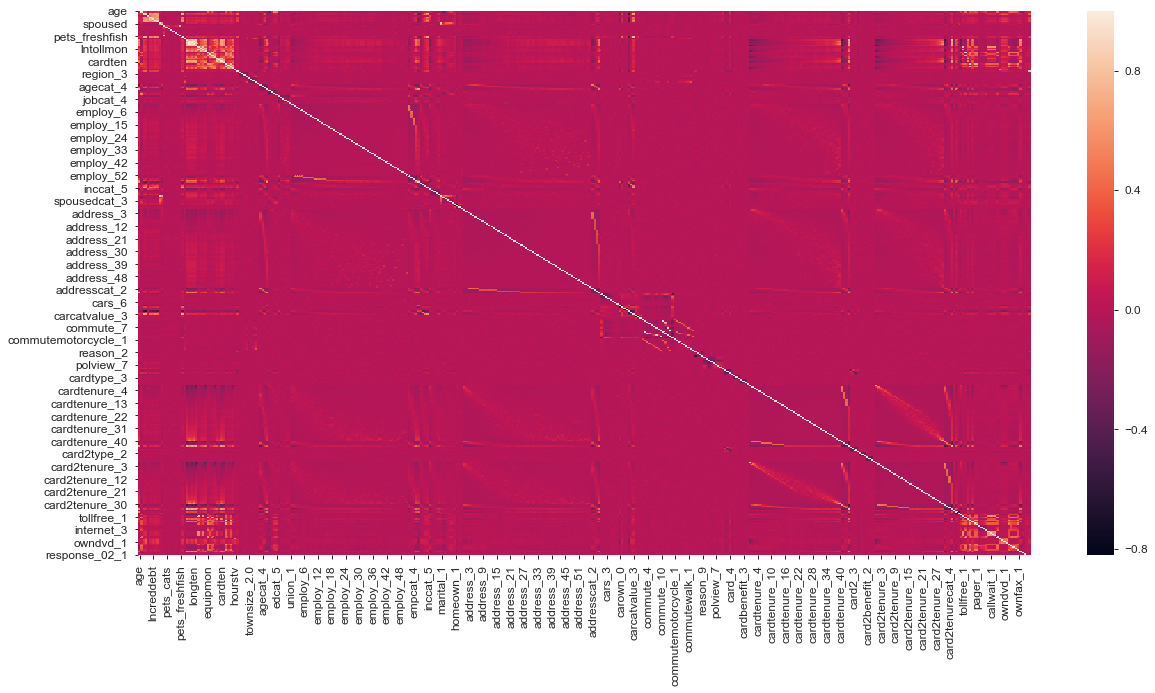

In [885]:
# visualize correlation matrix in Seaborn using a heatmap
plt.figure(figsize = (20, 10))
sns.heatmap(df.corr())


In [886]:
#Drop the y variables(totalspend) from dataframe because we are looking correlation between all x variables

# df.drop(['totalspend'],axis=1,inplace=True)

In [887]:
#Splitting the data in all x variable and y variable.

feature_columns = df.columns.difference(['ln_totalspend', 'totalspend'])

### Devide data into train and test data 

### Try to build a Model 2

In [892]:
train_x,test_x,train_y,test_y=train_test_split(df[feature_columns],
                                               df['ln_totalspend'],
                                               test_size=.3,
                                               random_state=123)

In [893]:
# method 2: divide the data into training and testing
train, test = train_test_split(df, test_size = 0.3, random_state = 123)

In [895]:
print ('Length of train_x   :', len(train_x))
print ('Length of test_x    :', len(test_x))
print ('Length of train_y   :', len(train_y))
print ('Length of test_y    :', len(test_y))

Length of train_x   : 3500
Length of test_x    : 1500
Length of train_y   : 3500
Length of test_y    : 1500


In [896]:
feature_columns

Index(['active_1', 'address_1', 'address_10', 'address_11', 'address_12',
       'address_13', 'address_14', 'address_15', 'address_16', 'address_17',
       ...
       'townsize_2.0', 'townsize_3.0', 'townsize_4.0', 'townsize_5.0',
       'union_1', 'voice_1', 'vote_1', 'wireless_1', 'wiremon', 'wireten'],
      dtype='object', length=388)

In [897]:
model_param = 'ln_totalspend ~' + '+'.join(feature_columns)

In [898]:
model_param = '''ln_totalspend ~ age + address_1 + card_2 + card_3 + card_4 + card_5 + card2_2 + card2_3 + card2_4
                + card2_5 + card2benefit_2 + lncreddebt + lninc + marital_1 + reason_2  + reason_9 +
                region_5 + spoused + spousedcat_1 + spousedcat_2 + spousedcat_3 '''

In [899]:
lm2 = sm.ols(model_param, train).fit()

In [900]:
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:          ln_totalspend   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     89.00
Date:                Wed, 18 Mar 2020   Prob (F-statistic):          3.96e-305
Time:                        22:29:04   Log-Likelihood:                -2739.4
No. Observations:                3500   AIC:                             5523.
Df Residuals:                    3478   BIC:                             5658.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.4963      0.078     70.

### feature selection based on importance using F - Regression

In [901]:
# Feature Selection based on importance
from sklearn.feature_selection import f_regression
features = train_x
target = train_y
F_values, p_values  = f_regression(features, target )

In [902]:
features.columns

Index(['active_1', 'address_1', 'address_10', 'address_11', 'address_12',
       'address_13', 'address_14', 'address_15', 'address_16', 'address_17',
       ...
       'townsize_2.0', 'townsize_3.0', 'townsize_4.0', 'townsize_5.0',
       'union_1', 'voice_1', 'vote_1', 'wireless_1', 'wiremon', 'wireten'],
      dtype='object', length=388)

In [912]:
f_reg_results = pd.concat([pd.Series(features.columns), 
                pd.Series(F_values),
                pd.Series(p_values)], axis = 1)

f_reg_results.columns = ['var_name', 'F_value', 'p_value']
f_reg_results['var_significance'] = np.where(f_reg_results.p_value < 0.1, 'Sig', 'In-Sig')

In [913]:
round(f_reg_results[(f_reg_results.var_significance == 'Sig') & (f_reg_results.p_value < 0.05)].head(50), 3)

,var_name,F_value,p_value,var_significance
1,address_1,12.773,0.000,Sig
23,address_3,9.769,0.002,Sig
26,address_32,3.904,0.048,Sig
34,address_4,4.076,0.044,Sig
59,addresscat_4,11.298,0.001,Sig
63,agecat_4,17.737,0.000,Sig
64,agecat_5,54.490,0.000,Sig
65,agecat_6,44.297,0.000,Sig
66,bfast_2,8.531,0.004,Sig
67,bfast_3,9.490,0.002,Sig


In [914]:
# # method 2: for creating dataframe of output of f_regression
# import itertools
# f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(features.columns, F_values,  ['%.3f' % p for p in p_values])]
# f_reg_results = pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])
# # f_reg_results

In [915]:
f_reg_results.sort_values(by = ['p_value'])
f_reg_results.p_value = pd.to_numeric(f_reg_results.p_value, errors='coerce')

In [916]:
f_reg_results_new = f_reg_results[f_reg_results.p_value <= 0.05]
f_columns = list(f_reg_results_new.var_name)

In [918]:
f_columns

['address_1',
 'address_3',
 'address_32',
 'address_4',
 'addresscat_4',
 'agecat_4',
 'agecat_5',
 'agecat_6',
 'bfast_2',
 'bfast_3',
 'callid_1',
 'callwait_1',
 'carcatvalue_1',
 'carcatvalue_2',
 'carcatvalue_3',
 'card2_2',
 'card2_3',
 'card2_4',
 'card2_5',
 'card2benefit_3',
 'card2tenure_26',
 'card2tenure_8',
 'card2tenurecat_2',
 'card_2',
 'card_3',
 'card_4',
 'card_5',
 'cardtenure_13',
 'cardtenure_31',
 'cardtenure_4',
 'cardtenurecat_5',
 'carown_0',
 'carown_1',
 'carvalue',
 'commute_4',
 'commutebike_1',
 'confer_1',
 'creddebt',
 'ed',
 'edcat_2',
 'edcat_3',
 'edcat_4',
 'edcat_5',
 'empcat_4',
 'empcat_5',
 'employ_1',
 'employ_16',
 'employ_17',
 'employ_24',
 'employ_32',
 'equip_1',
 'equipmon',
 'equipten',
 'forward_1',
 'gender_1',
 'homeown_1',
 'hometype_2',
 'hourstv',
 'inccat_2',
 'inccat_3',
 'inccat_4',
 'inccat_5',
 'income',
 'internet_3',
 'internet_4',
 'jobcat_2',
 'jobcat_3',
 'jobsat_4',
 'jobsat_5',
 'lncreddebt',
 'lnequipmon',
 'lnequipte

If p - values are less, then variables are siginificant in the regression equation.

####  VIF (Variance Inflation Factor): Check the multicollinieirity for all the variables in the model

In [919]:
model_param = 'ln_totalspend ~ ' + ' + '.join(f_columns)

In [920]:
model_param

'ln_totalspend ~ address_1 + address_3 + address_32 + address_4 + addresscat_4 + agecat_4 + agecat_5 + agecat_6 + bfast_2 + bfast_3 + callid_1 + callwait_1 + carcatvalue_1 + carcatvalue_2 + carcatvalue_3 + card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 + card2tenure_26 + card2tenure_8 + card2tenurecat_2 + card_2 + card_3 + card_4 + card_5 + cardtenure_13 + cardtenure_31 + cardtenure_4 + cardtenurecat_5 + carown_0 + carown_1 + carvalue + commute_4 + commutebike_1 + confer_1 + creddebt + ed + edcat_2 + edcat_3 + edcat_4 + edcat_5 + empcat_4 + empcat_5 + employ_1 + employ_16 + employ_17 + employ_24 + employ_32 + equip_1 + equipmon + equipten + forward_1 + gender_1 + homeown_1 + hometype_2 + hourstv + inccat_2 + inccat_3 + inccat_4 + inccat_5 + income + internet_3 + internet_4 + jobcat_2 + jobcat_3 + jobsat_4 + jobsat_5 + lncreddebt + lnequipmon + lnequipten + lninc + lnlongmon + lnlongten + lnothdebt + lntollmon + lntollten + lnwiremon + lnwireten + multline_1 + othdebt + owncd_1 

In [921]:
# High VIF of the variable means information in that variable has already been explained by 
# other X variables present in the model

# import the packages for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# separate the Y and X variables
y, X = dmatrices(model_param, train, return_type = 'dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF_Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# display the output
vif.round(1)

,Features,VIF_Factor
0,Intercept,40608.8
1,address_1,1.2
2,address_3,1.1
3,address_32,1.1
4,address_4,1.1
...,...,...
105,voice_1,2.2
106,vote_1,1.1
107,wireless_1,190.0
108,wiremon,271.6


In [922]:
model_param = '''ln_totalspend ~ age + address_1 + card_2 + card_3 + card_4 + card_5 + card2_2 + card2_3 + card2_4
                + card2_5 + card2benefit_2 + lncreddebt + lninc + marital_1 + reason_2  + reason_9 +
                region_5'''

In [923]:
lm2 = smf.ols(model_param, train).fit()

### On training data

In [924]:
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:          ln_totalspend   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     108.9
Date:                Wed, 18 Mar 2020   Prob (F-statistic):          2.74e-306
Time:                        22:30:27   Log-Likelihood:                -2746.1
No. Observations:                3500   AIC:                             5528.
Df Residuals:                    3482   BIC:                             5639.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.5388      0.077     71.

### On testing data

In [925]:
lm_test = sm.ols(model_param, test).fit()

In [926]:
print(lm_test.summary())

                            OLS Regression Results                            
Dep. Variable:          ln_totalspend   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     45.82
Date:                Wed, 18 Mar 2020   Prob (F-statistic):          1.01e-122
Time:                        22:30:36   Log-Likelihood:                -1086.6
No. Observations:                1500   AIC:                             2209.
Df Residuals:                    1482   BIC:                             2305.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.6017      0.108     51.

#### execute the model on training and testing samples

In [927]:
# Step 4: predict the sales on the training data
train['pred_spend'] = np.exp(lm2.predict(train))

In [928]:
# Step 5: predict the sales on the testing/validation data
test['pred_spend'] = np.exp(lm2.predict(test))

In [929]:
# Step 6: accuracy metrics (a. MAPE: Mean Absolute Percentage Error)
MAPE_train = '%.3f' % np.mean(np.abs(train.totalspend - train.pred_spend)/train.totalspend)
MAPE_test = '%.3f' % np.mean(np.abs(test.totalspend - test.pred_spend)/test.totalspend)

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.480  |  MAPE of testing data:  0.442


In [930]:
# Step 6: accuracy metrics (b. RMSE: Root Mean Squared Error)
RMSE_train = np.sqrt(mean_squared_error(train.totalspend ,train.pred_spend).round(3))
RMSE_test = np.sqrt(mean_squared_error(test.totalspend ,test.pred_spend).round(3))

# print the values of RMSE for train and test
print('RMSE of training data: ', RMSE_train,  ' | ', 'RMSE of testing data: ', RMSE_test)

RMSE of training data:  267.46950854256266  |  RMSE of testing data:  264.90983182962464


In [931]:
# Step 6: accuracy metrics (c. Correlation)
Corr_train = stats.stats.pearsonr(train.totalspend, train.pred_spend)
Corr_test = stats.stats.pearsonr(test.totalspend, test.pred_spend)

# print the values of Correlation for train and test
print('Correlation of training data: ', Corr_train,  ' | ', 'Correlation of testing data: ', Corr_test)

Correlation of training data:  (0.6000999888433307, 0.0)  |  Correlation of testing data:  (0.570039269970805, 5.404409490318112e-130)


In [932]:
# Step 6: accuracy metrics (d. Decile Analysis: for validation of models - Business validation)

# create the 10 groups in the data
train['Deciles'] = pd.qcut(train['pred_spend'], 10, labels = False)
test['Deciles'] = pd.qcut(test['pred_spend'], 10, labels = False)

# Decile Analysis for train data
Predicted_avg = train[['Deciles', 'pred_spend']].groupby(train.Deciles).mean().sort_index(ascending = False)['pred_spend']
Actual_avg = train[['Deciles', 'totalspend']].groupby(train.Deciles).mean().sort_index(ascending = False)['totalspend']
Decile_analysis_train = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# Decile Analysis for test data
Predicted_avg = test[['Deciles', 'pred_spend']].groupby(test.Deciles).mean().sort_index(ascending = False)['pred_spend']
Actual_avg = test[['Deciles', 'totalspend']].groupby(test.Deciles).mean().sort_index(ascending = False)['totalspend']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

# write the data into the file
Decile_analysis_train.to_csv('Decile_analysis_train.csv')
Decile_analysis_test.to_csv('Decile_analysis_test.csv')

In [933]:
Decile_analysis_test

,Deciles,pred_spend,totalspend
0,9,848.110512,858.283245
1,8,626.691041,725.399480
2,7,537.959364,598.926549
3,6,468.539086,515.696600
4,5,416.695451,513.209632
5,4,373.452282,448.103533
6,3,336.598922,370.219251
7,2,305.605165,358.444733
8,1,274.628133,332.383203
9,0,227.059373,274.699904


In [934]:
Decile_analysis_train

,Deciles,pred_spend,totalspend
0,9,846.373161,930.757830
1,8,615.251103,695.344527
2,7,519.624426,573.145170
3,6,454.951279,534.209763
4,5,404.981689,454.479079
5,4,364.976688,415.228079
6,3,331.551947,385.318008
7,2,301.349836,340.598280
8,1,270.206868,319.106051
9,0,221.475009,260.017528


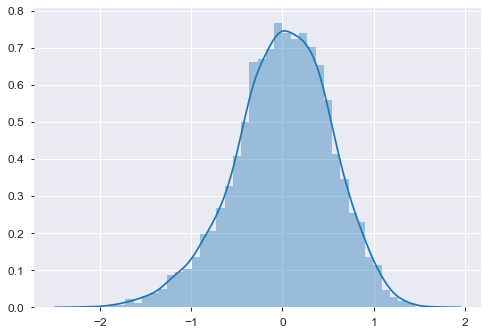

In [935]:
# assumption: Normality of the residuals/error (using distplot)
sns.distplot(lm2.resid)
plt.show()

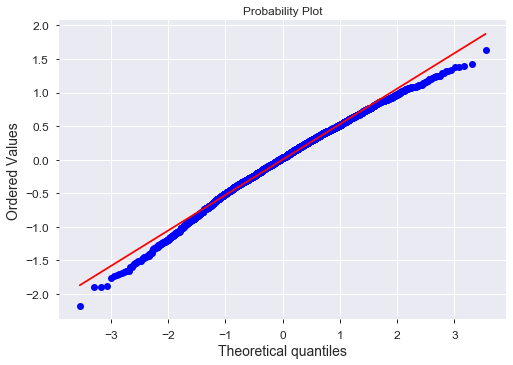

In [936]:
# assumption: Normality of the residuals/error (using Q-Q plot)
from scipy import stats
import pylab

stats.probplot(lm2.resid, dist = 'norm', plot = pylab)
pylab.show()

# If errors are normally and randomly distributed, they would be following a straight line pattern
# Q-Q plot shows if the residuals are plotted along the line

In [937]:
# assumption: mean of residuals/errors is zero
print(lm2.resid.mean())

3.36333627615204e-13


In [938]:
# assumption: residuals/errors of the model should not be correlated with dependant (Y) variable
print(stats.stats.pearsonr(lm2.resid, train.ln_totalspend))

(0.8080580467776977, 0.0)


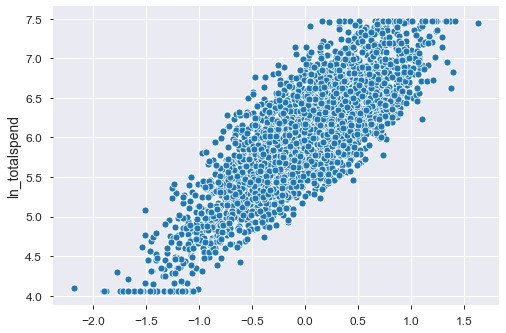

In [939]:
sns.scatterplot(lm2.resid, train.ln_totalspend)

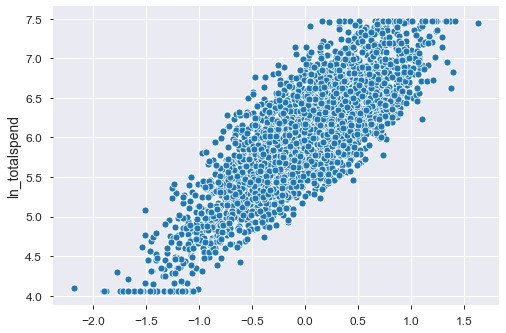

In [940]:
# assumption: homoscedasticity of residuals/errors
sns.scatterplot(lm2.resid, train.ln_totalspend)
plt.show()